# Modelos: Deep Factorization Machine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

from torchviz import make_dot

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-24 14:10:53,791 - INFO - Train: 83.74 % - Test: 7.71 %


## Definicion del modelo

In [13]:
params = Bunch({
    'lr': 0.0001,
    'epochs': 30,
    'embedding_size': 50,
    'units_per_layer': [50, 10],
    'dropout': 0.2,
    'n_workers': 24,
    'batch_size': 64,
    'features_n_values': [len(it) for it in dataset.features_uniques],
    'device': get_device()
})

In [14]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [15]:
model = ml.DeepFM(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(params.device)
model
# make_dot(y_pred, params=dict(model.named_parameters()))

DeepFM(
  (lineal): CategoricalFeaturesLineal(
    (embedding): MultiFeatureEmbedding(
      (embedding): Embedding(31503, 1)
    )
  )
  (fm): EmbeddingFactorizationMachine()
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(31503, 50)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=50, out_features=10, bias=True)
      (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (act): ReLU()
)

## Entrenamiento del modelo

<Figure size 720x432 with 1 Axes>

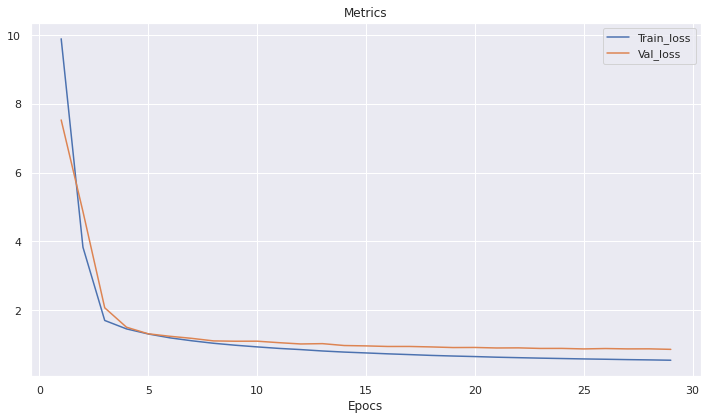

In [25]:
logging.info(f'Iteration {it}')
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs=1
        ),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=1),
        SaveBestModel(metric='val_loss', path='../weights', experiment_name='deep_fm')
    ]
)

## Evaluación del modelo

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

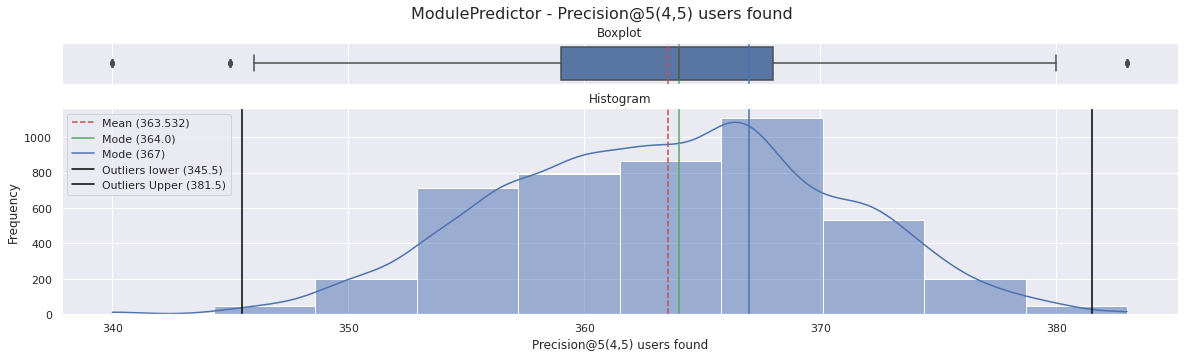


Metrics:



,"Precision@5(4,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

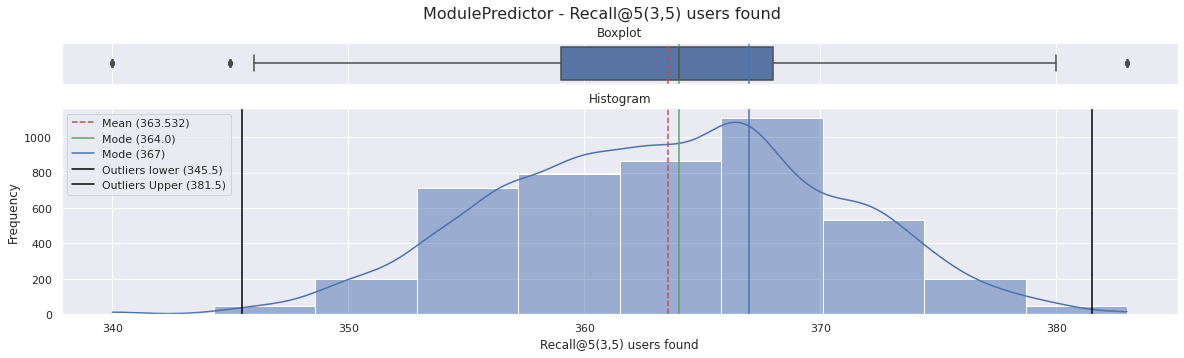


Metrics:



,"Recall@5(3,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

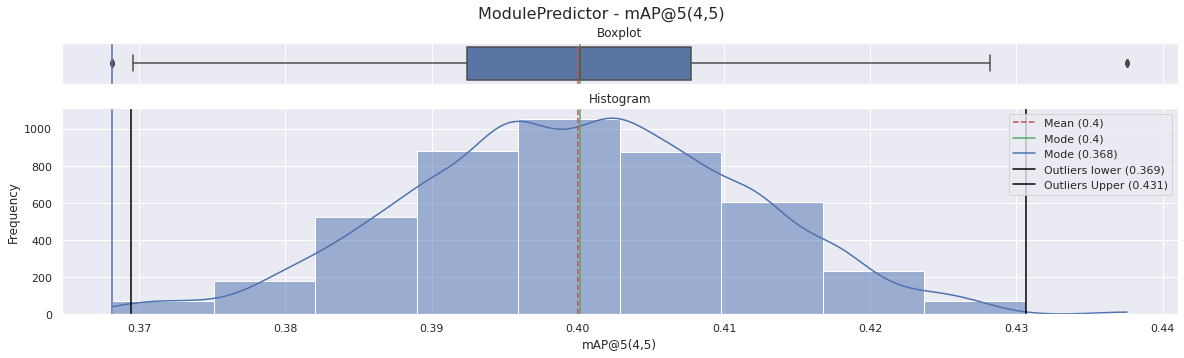


Metrics:



,"mAP@5(4,5)"
count,4500.000000
mean,0.400027
std,0.011356
min,0.368163
25%,0.392407
50%,0.400147
75%,0.407716
max,0.437567


<Figure size 1440x360 with 2 Axes>

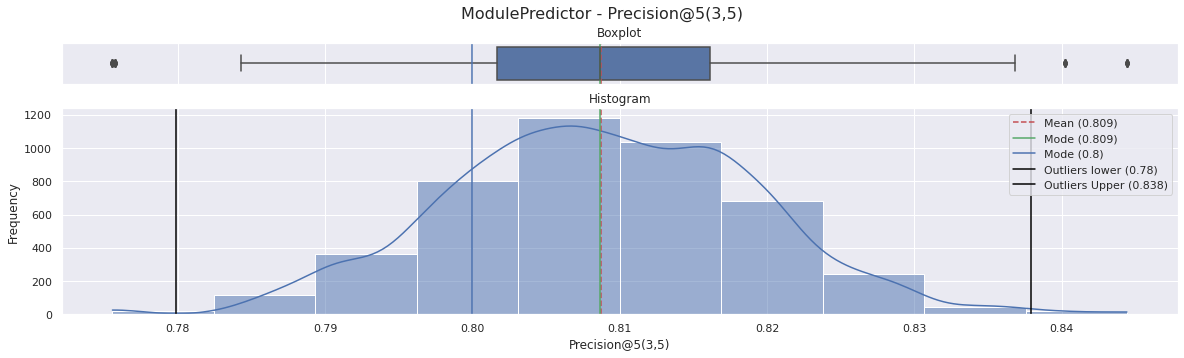


Metrics:



,"Precision@5(3,5)"
count,4500.000000
mean,0.808746
std,0.010429
min,0.775556
25%,0.801635
50%,0.808660
75%,0.816160
max,0.844444


<Figure size 1440x360 with 2 Axes>

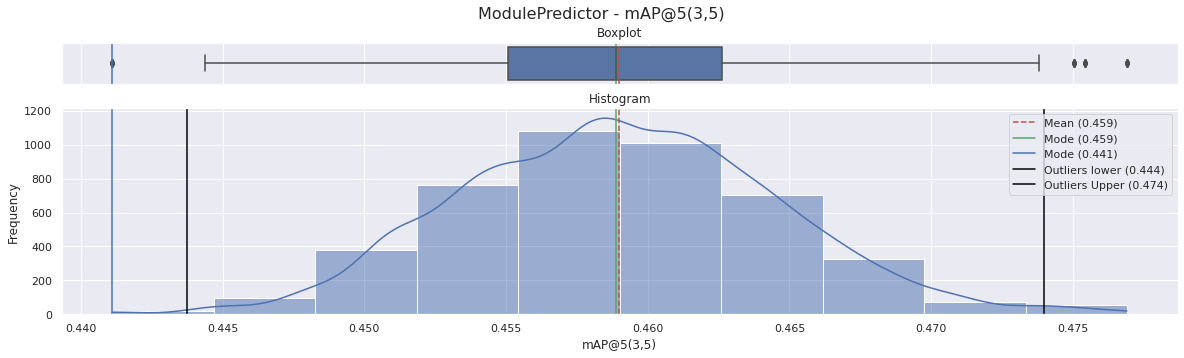


Metrics:



,"mAP@5(3,5)"
count,4500.000000
mean,0.458980
std,0.005586
min,0.441110
25%,0.455076
50%,0.458875
75%,0.462633
max,0.476911


<Figure size 1440x360 with 2 Axes>

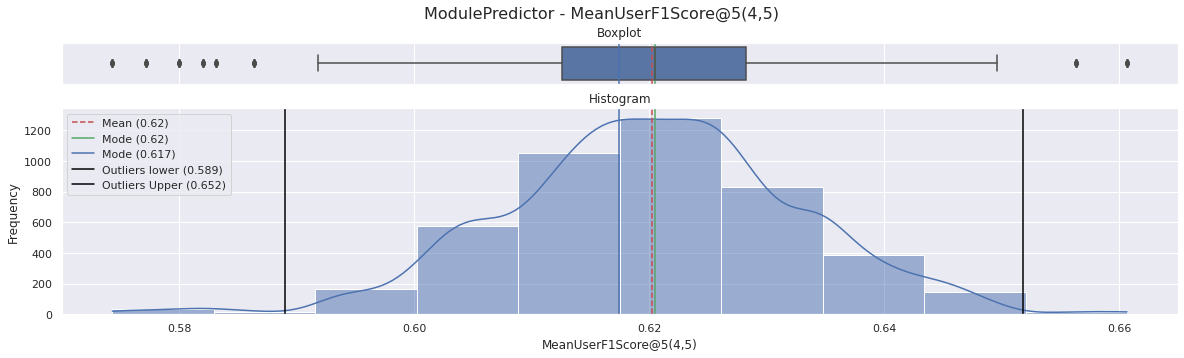


Metrics:



,"MeanUserF1Score@5(4,5)"
count,4500.000000
mean,0.620186
std,0.012590
min,0.574302
25%,0.612526
50%,0.620485
75%,0.628222
max,0.660656


<Figure size 1440x360 with 2 Axes>

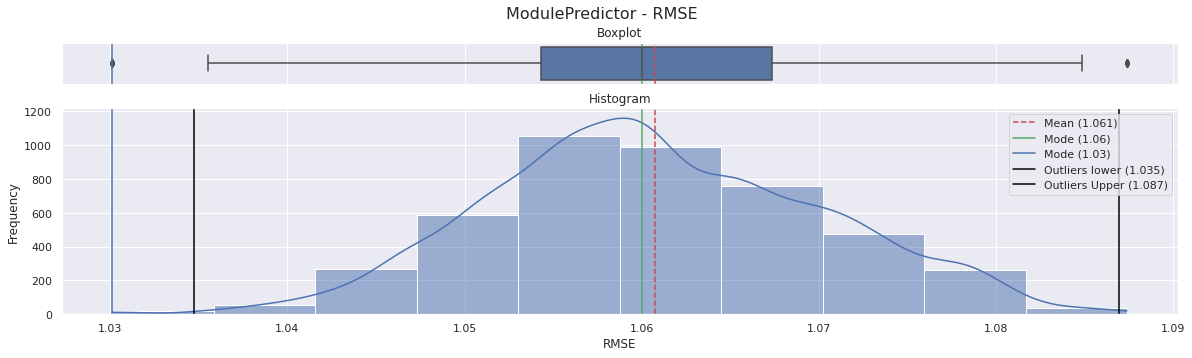


Metrics:



,RMSE
count,4500.000000
mean,1.060771
std,0.009458
min,1.030116
25%,1.054317
50%,1.060050
75%,1.067382
max,1.087412


<Figure size 1440x360 with 2 Axes>

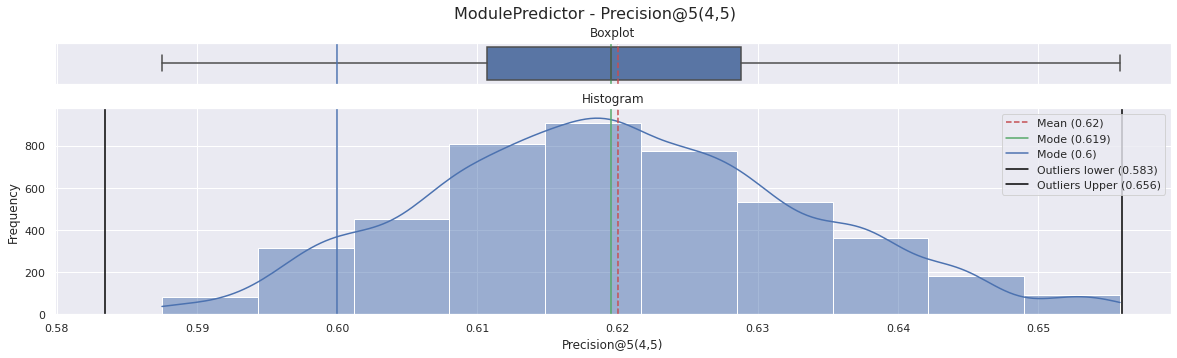


Metrics:



,"Precision@5(4,5)"
count,4500.000000
mean,0.620007
std,0.013346
min,0.587500
25%,0.610668
50%,0.619499
75%,0.628802
max,0.655827


<Figure size 1440x360 with 2 Axes>

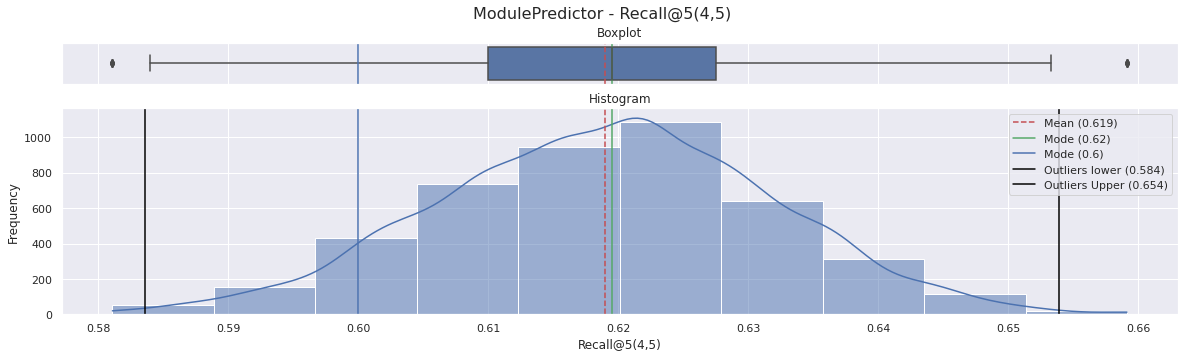


Metrics:



,"Recall@5(4,5)"
count,4500.000000
mean,0.619003
std,0.012889
min,0.581111
25%,0.609993
50%,0.619532
75%,0.627568
max,0.659155


<Figure size 1440x360 with 2 Axes>

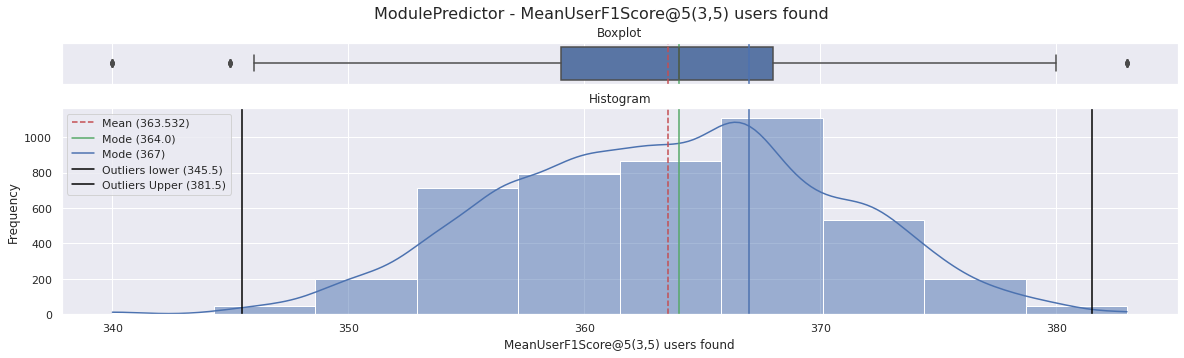


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

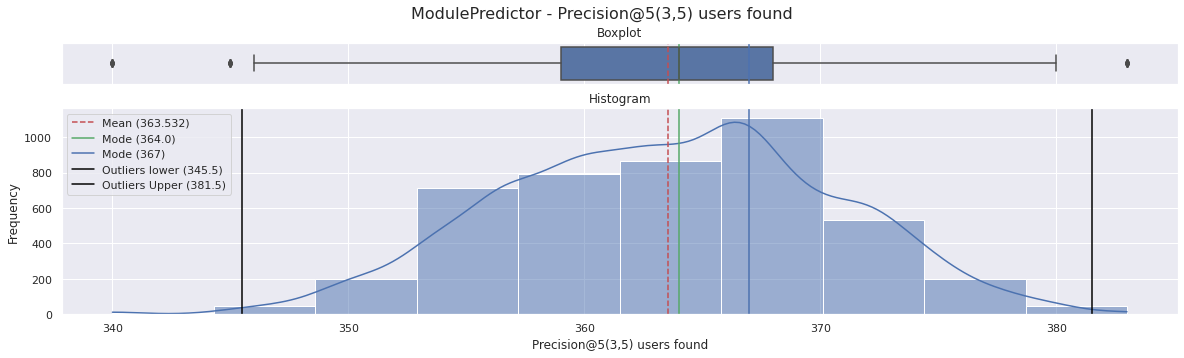


Metrics:



,"Precision@5(3,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

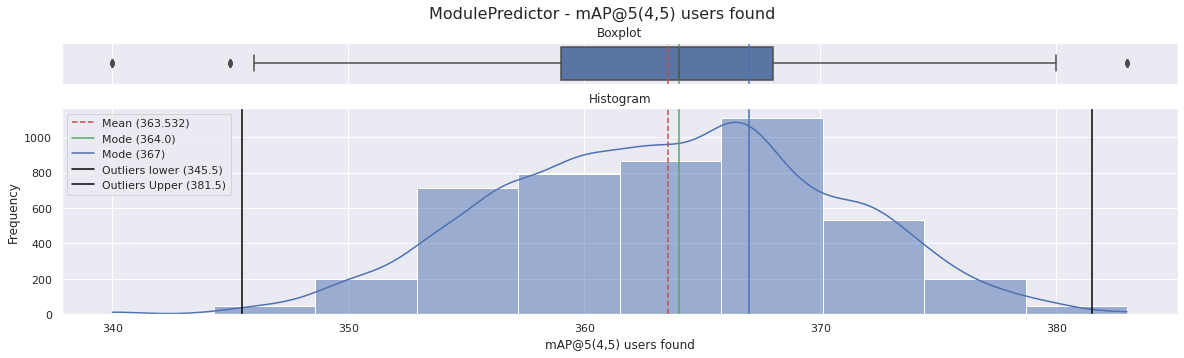


Metrics:



,"mAP@5(4,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

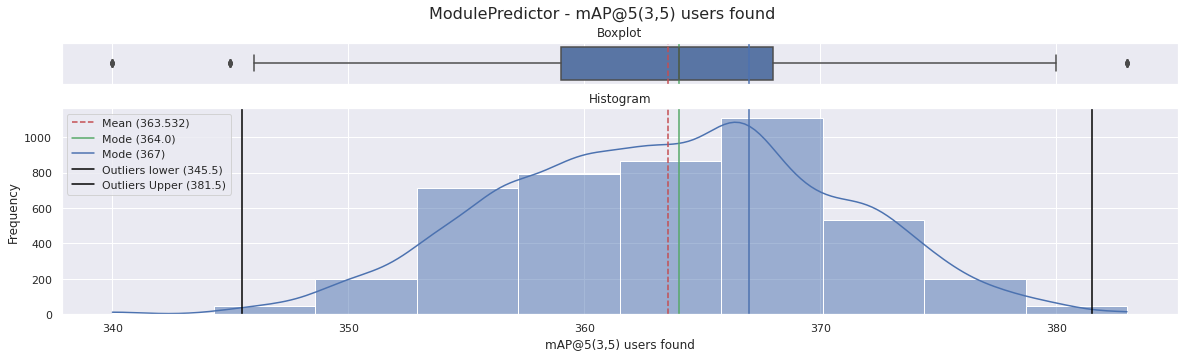


Metrics:



,"mAP@5(3,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

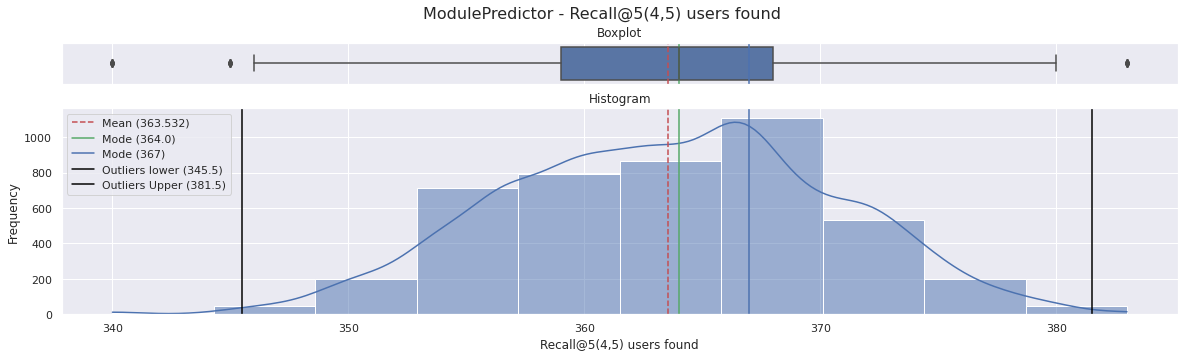


Metrics:



,"Recall@5(4,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

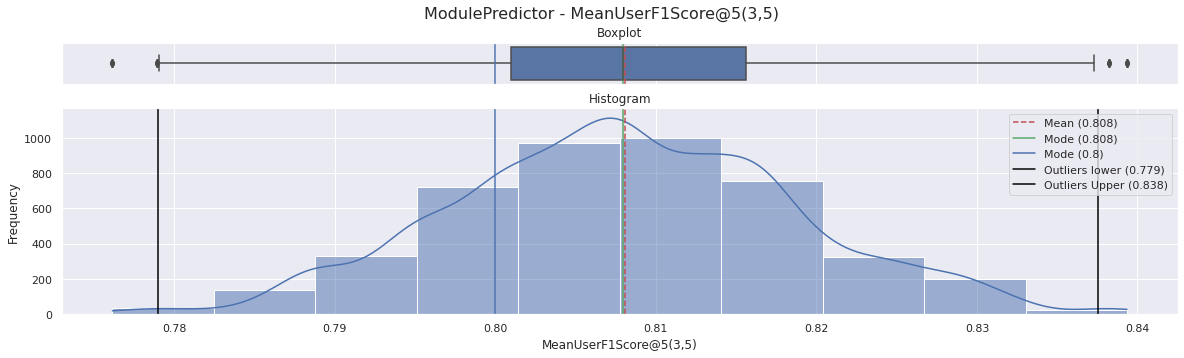


Metrics:



,"MeanUserF1Score@5(3,5)"
count,4500.000000
mean,0.808098
std,0.010705
min,0.776152
25%,0.800947
50%,0.807957
75%,0.815591
max,0.839344


<Figure size 1440x360 with 2 Axes>

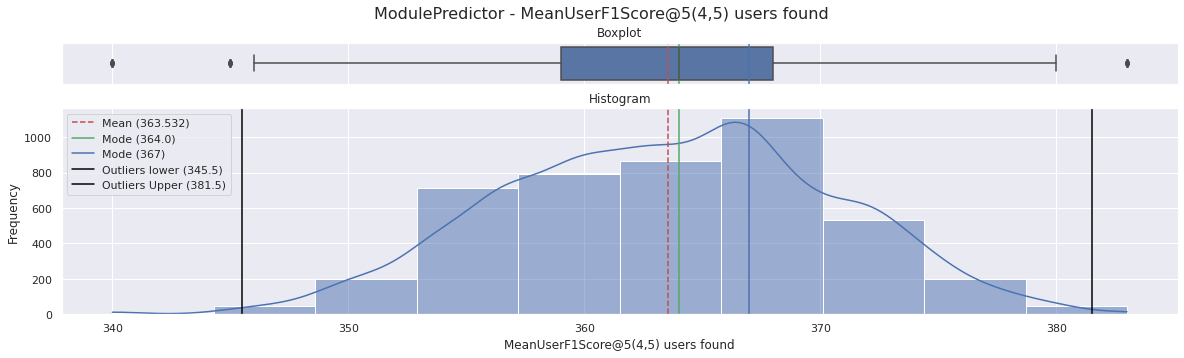


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,4500.000000
mean,363.532000
std,7.011412
min,340.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

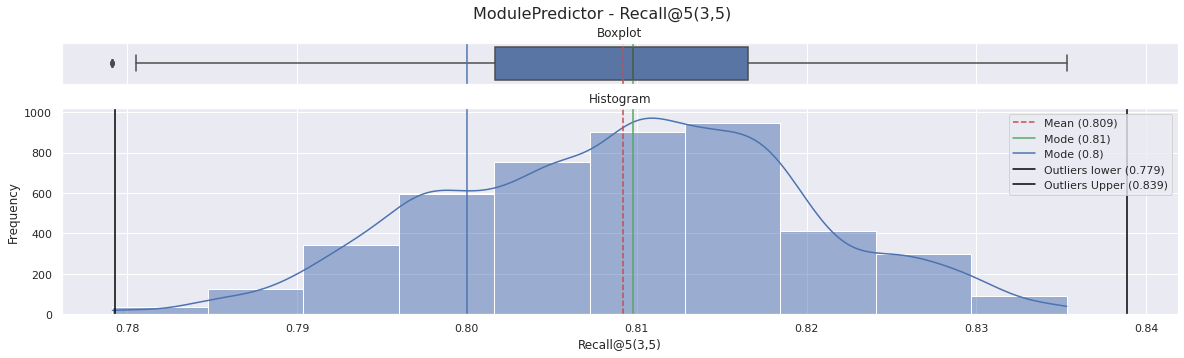


Metrics:



,"Recall@5(3,5)"
count,4500.000000
mean,0.809195
std,0.010443
min,0.779121
25%,0.801633
50%,0.809783
75%,0.816529
max,0.835326


In [16]:
PATH = '../weights/2022-07-23_17-18-18--deep_fm--epoch_29--val_loss_0.8562266826629639.pt'
model.load_state_dict(torch.load(PATH))

deep_fm_predictor = ml.ModulePredictor(model)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(3, 5))
    ],
    predictors = [deep_fm_predictor]
)

summary = validator.validate(eval_set)

summary.save('../metrics/deep_fm')
summary = ml.ValidatorSummary.load('../metrics/deep_fm')

summary.plot(bins=10, show_table=True)